## Latent Space and Song Orders
We can now look at the trained samples in latent space. The latent space is a 2 dimensional representation of the wavesets ordered by similiarity. Each waveset is a point in the 2D space. We can think of a song as a series of jumps from waveset to waveset, i.e. a series of 2D coordinates. We want to save these series and train another network to create a new series.

In [1]:
from Variational_Autoencoder_alla_Valerio import VAE as Autoencoder
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa.feature.inverse
from IPython.display import display, Audio

First we load the trained autoencoder and the training data from our disk:

In [2]:
subfolder = "1.0_16"
model_name = "VAE_128D_5000samples_20Epochs"
autoencoder = Autoencoder.load("data_and_models\\" + subfolder +"\\" + model_name)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "Valerio"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 16, 1)]      0         
                                                                 
 encoder (Functional)        (None, 128)               1642080   
                                                                 
 decoder (Functional)        (None, 256, 16, 1)        434017    
                                                                 
Total params: 2,076,097
Trainable params: 2,073,153
Non-trainable params: 2,944
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputL

In [3]:
def load_data(subfolder):
    spectogram_data = np.load("data_and_models\\" + subfolder + "\spectos.npy")
    song_labels = np.load("data_and_models\\" + subfolder + "\song_labels.npy")
    position_labels = np.load("data_and_models\\" + subfolder + "\position_labels.npy")
    print(spectogram_data.shape)
    
    return spectogram_data, position_labels, song_labels

x_train, y_train, y_train_alt = load_data(subfolder)

x_train = x_train[0:autoencoder.num_of_train_data]
y_train = y_train[0:autoencoder.num_of_train_data]
y_train_alt = y_train_alt[0:autoencoder.num_of_train_data]

(141614, 256, 16, 1)


## Data in latent space
We can now plot our wavesets in the latent space. Each waveset is reduced to a point in the 2 dimensional space. The distance between the points of two wavesets corresponds to their similarity. The colors represent at which position in a song the waveset occured (first 10% of the song, second 10% of the song and so on).

In [4]:
latent_representation = autoencoder.encoder.predict(x_train)

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


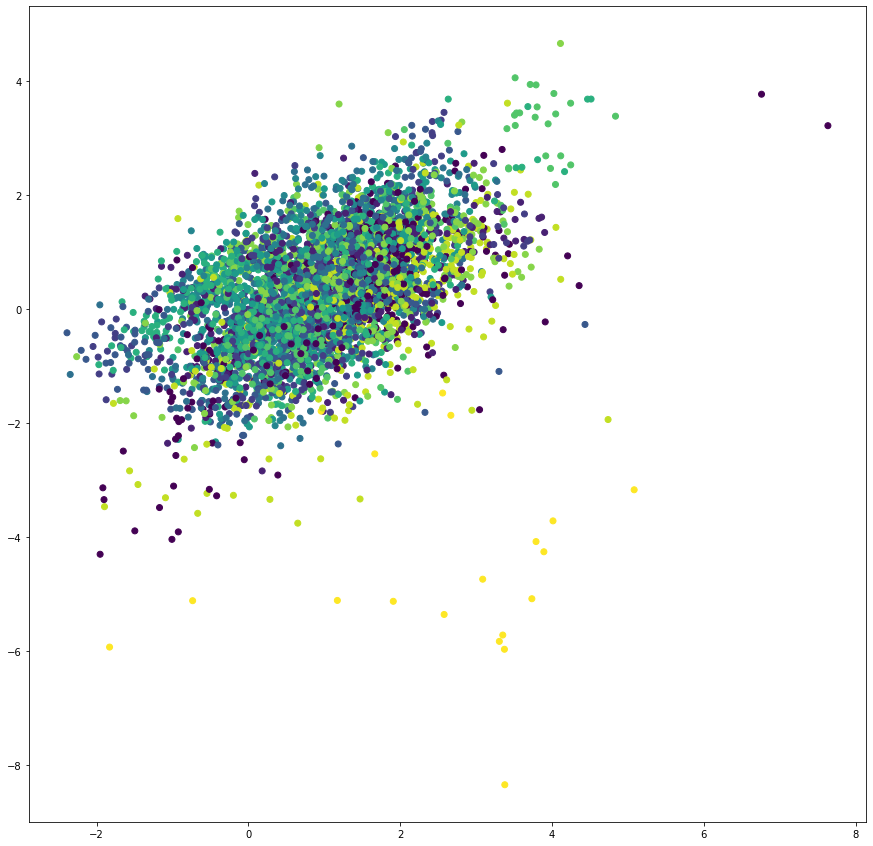

In [5]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=y_train)
plt.show()

## Generate Song Orders
A song is a series of wavesets. This series of wavesets corresponds to a list of coordinates in the latent space. It can be imagined as a movement - or more precisely a sequence of jumps - through the latent space. Later we want to use these sequences as training data for a second network. On their basis the second network will be able to produce new sequences. For this we need to store the series of coordinates for each song. We create a list of 2D arrays: first dimension is the song, and second dimension is the a tuple of coordinates.

In [6]:
num_of_ws_per_song = np.load("data_and_models\\" + subfolder + "\WSnum.npy")

ws_sums = np.cumsum(num_of_ws_per_song)
num_of_ws_per_song = num_of_ws_per_song[:np.argwhere(ws_sums > x_train.shape[0]).min()]

start_ws = 0
stop_ws = 0
song_orders = []

for i, num_of_ws in enumerate(num_of_ws_per_song):
    stop_ws += num_of_ws
    song_order = latent_representation[start_ws : stop_ws]
    song_order = np.reshape(song_order, (num_of_ws, 2))
    song_orders.append(song_order)
    start_ws += num_of_ws
    
song_orders = np.asarray(song_orders, dtype=object)

ValueError: cannot reshape array of size 27136 into shape (212,2)

We save the new list of song_orders on disk for later use:

In [ ]:
save_path = "data_and_models\\" + subfolder + "\\" + str(autoencoder.model.name) +"_" + str(autoencoder.num_of_train_data)+"_song_orders" + ".npy"
np.save(save_path,song_orders)

## The latent space representation of one song
We can plot the latent representation of a song. The subsequent wavesets are connected by lines to visualize, that the sequence of wavesets corresponds to a path trough the latent space.

In [ ]:
song_num = 0
plt.figure(figsize=(20,20))
plt.plot(song_orders[song_num][:, 0], song_orders[song_num][:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

## Create a new Waveset
We can now sample a new point in the latent space and create the corresponding waveset by passing the coordinates to our decoder. 

In [7]:
def reconstruct(data):
    latent_representations = autoencoder.encoder.predict(data)
    reconstructed_ws = autoencoder.decoder.predict(latent_representations)
    reconstructed_ws = denormalise(reconstructed_ws,0,1, -100, 100)
    return reconstructed_ws

def denormalise(array, current_min, current_max, original_min, original_max):
        denorm_array = (array - current_min) / (current_max - current_min)
        denorm_array = denorm_array * (original_max - original_min) + original_min
        return denorm_array


Original Specto:



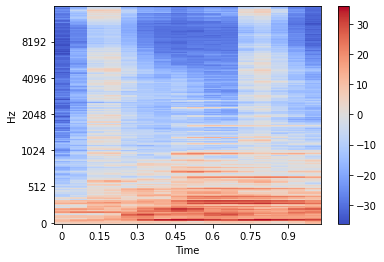

Reconstructed Specto:



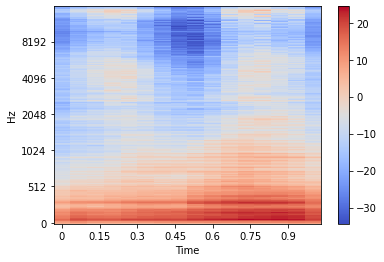

In [8]:

sr = 44100
WIN_LENGTH = int(44100/4)
HOP_LENGTH = int(44100/15)
N_FFT = int(44100/4)

def display_reconstructed_specto(index):

    reconstructed_ws = reconstruct(x_train[index:index+1])
    original_ws = denormalise(x_train[index],0,1,-100, 100)
    
    print("Original Specto:\n")
    librosa.display.specshow(
        original_ws.reshape(original_ws.shape[0],original_ws.shape[1]),
        x_axis='time',
        y_axis='mel',
        sr=44100,
        fmax=16000,
        hop_length=HOP_LENGTH,
    )
    plt.colorbar()
    plt.show()
    

    print("Reconstructed Specto:\n")
    librosa.display.specshow(
        reconstructed_ws[0].reshape(reconstructed_ws[0].shape[0],reconstructed_ws[0].shape[1]),
        x_axis='time',
        y_axis='mel',
        sr=sr,
        fmax=16000,
        hop_length=HOP_LENGTH,
    )
    plt.colorbar()
    plt.show()
    
    return reconstructed_ws, original_ws

recon_ws, original_ws = display_reconstructed_specto(np.random.randint(0,x_train.shape[0]))

In [9]:
WIN_LENGTH = int(44100 / 8)
HOP_LENGTH = int(44100 / 23)
N_FFT = int(44100 / 8)#


reshaped_specto = recon_ws.reshape(x_train[0].shape[0], x_train[0].shape[1],x_train[0].shape[2])[:, :, 0]
lin_specto = librosa.db_to_power(reshaped_specto)
pca = librosa.feature.inverse.mel_to_audio(lin_specto, sr=44100, hop_length=HOP_LENGTH, n_fft=N_FFT, win_length=WIN_LENGTH)

In [10]:
display(Audio(pca,rate=44100))

Reconstructed Specto:



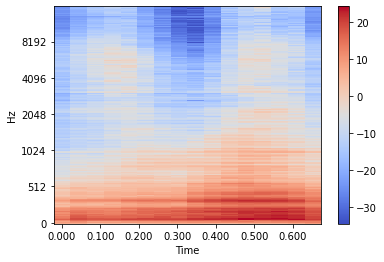

In [11]:
double_inverse =librosa.feature.melspectrogram(y=pca, sr=44100, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_fft=N_FFT, n_mels=256, fmax=16000)
double_inverse = librosa.power_to_db(double_inverse)
#double_inverse = double_inverse.reshape(x_train[0].shape[0], x_train[0].shape[1],x_train[0].shape[2])

print("Reconstructed Specto:\n")
librosa.display.specshow(
    double_inverse,
    x_axis='time',
    y_axis='mel',
    sr=sr,
    fmax=16000,
    hop_length=HOP_LENGTH,
)
plt.colorbar()
plt.show()

In [12]:
reshaped_specto = original_ws[:, :, 0]
lin_specto = librosa.db_to_power(reshaped_specto)
pca = librosa.feature.inverse.mel_to_audio(lin_specto, sr=44100, hop_length=HOP_LENGTH, n_fft=N_FFT, win_length=WIN_LENGTH)
print("This ist the original:")
display(Audio(pca,rate=44100))

This ist the original:
